## TSP using Genetic Algorithm

In [1]:
import random
import numpy as np
import pandas as pd
from itertools import permutations
import copy

In [2]:
class gene: # city
    def __init__(self, name, longitude, latitude):
      self.name = name
      self.longitude = longitude #x
      self.latitude = latitude #y

In [3]:
class Chromosome:
  def __init__(self, cost, fitness, geneslist):
    self.cost = cost
    self.fitness = fitness
    self.geneslist = geneslist

In [22]:
class TSP:
    def __init__(self, cities_list, population_size=50, generations_count=100, elitism_percentage=0.02, crossover_probability=0.6, mutation_probability=0.1):
      self.cities_list = cities_list
      self.population_size = population_size
      self.generations_count = generations_count
      self.elitism_percentage = elitism_percentage
      self.crossover_probability = crossover_probability
      self.mutation_probability = mutation_probability

    def calc_euclidean_distance(self, current_city, neighbor_city):
      return ((current_city.longitude - neighbor_city.longitude)**2 + (current_city.latitude - neighbor_city.latitude)**2)**0.5

    def calc_distance_matrix(self):
      distance_matrix = np.zeros((len(self.cities_list), len(self.cities_list)))
      for i in range(len(self.cities_list)):
        for j in range(i + 1, len(self.cities_list)):  #start from i + 1
          if i==j:
            continue
          else:
            distance = self.calc_euclidean_distance(self.cities_list[i], self.cities_list[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance
      return distance_matrix

    def Permutation(self):
      return np.random.permutation(self.cities_list)

    def calc_cost(self, geneslist, distance_matrix):
      cost = 0
      for i in range(len(geneslist)):
        current_city_index = int(geneslist[i].name) - 1
        next_city_index = int(geneslist[(i + 1) % len(geneslist)].name) - 1
        cost += distance_matrix[current_city_index][next_city_index]
      return cost

    def calc_fitness(self, chrom, distance_matrix):
      chrom.cost = self.calc_cost(chrom.geneslist, distance_matrix)
      chrom.fitness = 1/chrom.cost


    def init_population(self, distance_matrix):
      population = []
      for _ in range(self.population_size):
        chrom = Chromosome(None, None, self.Permutation())
        self.calc_fitness(chrom, distance_matrix)
        population.append(chrom)
      return population

    def elitism(self, population):
      elitism_count = max(2, int(self.elitism_percentage * self.population_size))
      sorted_population = sorted(population, key=lambda x: x.fitness, reverse=True)
      elite_chromosomes = copy.deepcopy(sorted_population[:elitism_count]) #parents that elite to the new generatoin
      return elite_chromosomes

    def tournament_selection(self, population, k=5):
      tournament_candidates = random.sample(population, k)
      fittest_chromosome = max(tournament_candidates, key=lambda x: x.fitness)
      return fittest_chromosome

    def find_index(self,cities, name):
        for i, city in enumerate(cities):
            if city.name == name:
                return i
        return -1

    def apply_PMC_crossover(self, parent1, parent2): #partially mapped crossover
      crossover_point1 = random.randint(0, len(self.cities_list) - 1)
      crossover_point2 = random.randint(crossover_point1 + 1, len(self.cities_list))
      for i in range(crossover_point1, crossover_point2):
        index = self.find_index(parent1.geneslist, parent2.geneslist[i].name)
        parent1.geneslist[i], parent1.geneslist[index] = parent1.geneslist[index], parent1.geneslist[i]
      return parent1

    def PMC_crossover(self, population, new_generation, distance_matrix, k):
      crossover_children = []
      crossover_count = (self.population_size - len(new_generation))//2
      for i in range(crossover_count):
        parent1 = copy.deepcopy(self.tournament_selection(population, k))
        parent2 = copy.deepcopy(self.tournament_selection(population, k))
        if random.random() < self.crossover_probability:
          child1 = self.apply_PMC_crossover(parent1, parent2)
          child2 = self.apply_PMC_crossover(parent2, parent1)
          self.calc_fitness(child1, distance_matrix)
          self.calc_fitness(child2, distance_matrix)
          crossover_children.append(child1)
          crossover_children.append(child2)
        else:
          crossover_children.append(parent1)
          crossover_children.append(parent2)
      return crossover_children

    def apply_mutation(self, new_generation, distance_matrix):
      for _ in range(len(new_generation)):
        parent = random.choice(new_generation)
        if random.random() < self.mutation_probability:
          index1, index2 = random.sample(range(len(parent.geneslist)), 2)
          parent.geneslist[index1], parent.geneslist[index2] = parent.geneslist[index2], parent.geneslist[index1]
          self.calc_fitness(parent, distance_matrix)
      return new_generation


In [5]:
df = pd.read_csv("Data set CSV.csv")
df

,City,x,y
0,1,5.500000e-08,9.860000e-09
1,2,-2.887330e+01,-7.980000e-08
2,3,-7.929160e+01,-2.140330e+01
3,4,-1.465770e+01,-4.338960e+01
4,5,-6.474730e+01,2.189820e+01
5,6,-2.905850e+01,-4.321670e+01
6,7,-7.207850e+01,1.815810e-01
7,8,-3.603660e+01,-2.161350e+01
8,9,-5.048080e+01,7.374470e+00
9,10,-5.058590e+01,-2.158820e+01


In [6]:
cities_list = []
for i in range(len(df)):
  city_name = df.iloc[i, 0]
  longtitude = df.iloc[i, 1]
  latitude = df.iloc[i, 2]
  cities_list.append(gene(city_name, longtitude, latitude))

In [483]:
TSP1 = TSP(cities_list)
distance_matrix = TSP1.calc_distance_matrix()
population = TSP1.init_population(distance_matrix)
# old_population =[population]

# Genetic Algorithm Generation
for i in range(TSP1.generations_count):
  elite_chromosomes =[]
  elite_chromosomes = TSP1.elitism(population)
  crossover_children = TSP1.PMC_crossover(population, elite_chromosomes, distance_matrix, k=5)
  mutated_gen = TSP1.apply_mutation(crossover_children, distance_matrix)
  population = mutated_gen
  # old_population.append(population)
best_chromosome = max(population, key=lambda x: x.fitness)
print("Cost:", best_chromosome.cost)

Cost: 284.3810904080331


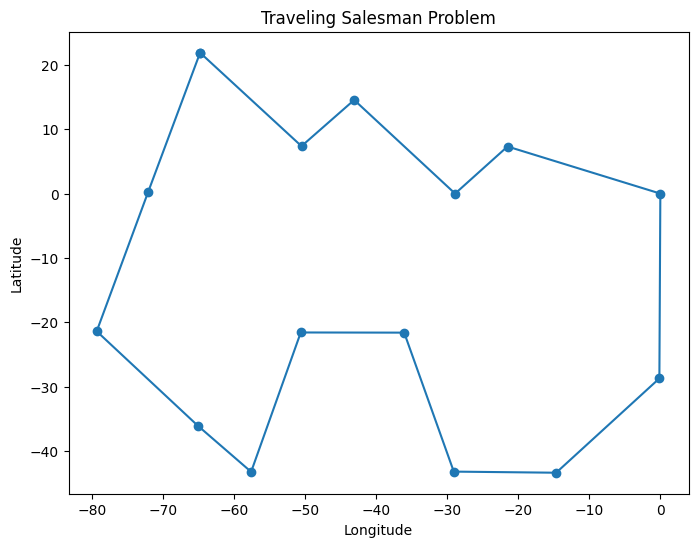

In [484]:
import matplotlib.pyplot as plt
x_coords = [city.longitude for city in best_chromosome.geneslist]
x_coords.append(best_chromosome.geneslist[0].longitude)
y_coords = [city.latitude for city in best_chromosome.geneslist]
y_coords.append(best_chromosome.geneslist[0].latitude)
plt.figure(figsize=(8, 6))
plt.plot(x_coords, y_coords, marker='o', linestyle='-')
plt.title('Traveling Salesman Problem')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()